# Import Brain Inverders Library

In [207]:
from braininvaders2015a.dataset import BrainInvaders2015a

import pandas as pd
import numpy as np

# Import Data

In [208]:
dataset = BrainInvaders2015a()

def loadData(subject, session = 'session_1', run = 'run_1'):
    data = dataset._get_single_subject_data(subject)
    data = data[session][run]
    # data.set_montage(ten_twenty_montage)
    return data

data_subjects = []
subjects = list(range(1,44))
subjects.remove(1)
subjects.remove(27)

In [209]:
for subject in subjects:
    data_subjects.append(loadData(subject))

# Preprocessing

## Preprocessing Functions

In [210]:
import mne
from mne import create_info
from mne import Epochs, find_events

from sklearn.decomposition import PCA

def df_to_raw(df):
    sfreq = 512
    ch_names = list(df.columns)
    ch_types = ['eeg'] * (len(df.columns) - 1) + ['stim']
    ten_twenty_montage = mne.channels.make_standard_montage('standard_1020')

    df = df.T
      #mne looks at the tranpose() format
    df[:-1] *= 1e-6
      #convert from uVolts to Volts (mne assumes Volts data)

    info = create_info(ch_names=ch_names, ch_types=ch_types, sfreq=sfreq)

    raw = mne.io.RawArray(df, info)
    raw.set_montage(ten_twenty_montage)
    return raw

def getEpochs(raw, event_id, tmin, tmax, picks):

    #epoching
    events = find_events(raw)
    
    #reject_criteria = dict(mag=4000e-15,     # 4000 fT
    #                       grad=4000e-13,    # 4000 fT/cm
    #                       eeg=100e-6,       # 150 μV
    #                       eog=250e-6)       # 250 μV

    reject_criteria = dict(eeg=100e-6)  #most voltage in this range is not brain components

    epochs = Epochs(raw, events=events, event_id=event_id, 
                    tmin=tmin, tmax=tmax, baseline=None, preload=True,verbose=False, picks=picks)  #8 channels
    print('sample drop %: ', (1 - len(epochs.events)/len(events)) * 100)

    return epochs
  
def preprocessing(rawdata, runPCA=False):
    # Convert and drop time column
    data_ses1_run1_pd = rawdata.to_data_frame()
    data_ses1_run1_pd = data_ses1_run1_pd.drop(['time'],axis = 1)
    raw = df_to_raw(data_ses1_run1_pd)

    # Notch Filter
    raw.notch_filter(np.arange(50, 251, 50))

    eeg_channels = mne.pick_types(raw.info, eeg=True)
      
    raw.filter(1,24,method = 'iir')


    if runPCA:
      raw_df = raw.to_data_frame()
      X1 = raw_df.drop(['time'],axis = 1)
      X = X1.drop(['STI 014'],axis = 1)
      y = raw_df['STI 014']
      pca = PCA(n_components=32)
      X = pca.fit(X.values).transform(X.values)
      y1 = y.values.reshape(-1,1)
      data = np.hstack((X,y1))
      df = pd.DataFrame(data, columns = list(X1.columns))
      raw = df_to_raw(df)

    event_id = {'NonTarget': 1, 'Target': 2}
    tmin = 0.0 #0
    tmax = 1.0 #0.5 seconds
    picks= eeg_channels
    epochs = getEpochs(raw,event_id, tmin, tmax, picks)

    X = epochs.get_data()
    y = epochs.events[:, -1]
    return X, y

## Preprocessing Data

In [211]:
from IPython.display import clear_output

X_subjects = []
y_subjects = []
runPCA = True

for data in data_subjects:
    X, y = preprocessing(data, runPCA=runPCA)    
    X_subjects.append(X)
    y_subjects.append(y)
    clear_output(wait=True)

Creating RawArray with float64 data, n_channels=33, n_times=129472
    Range : 0 ... 129471 =      0.000 ...   252.873 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3381 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 24 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 24.00 Hz: -6.02, -6.02 dB

Creating RawArray with float64 data, n_channels=33, n_times=129472
    Range : 0 ... 129471 =      0.000 ...   252.873 secs
Ready.
360 events found
Event IDs: [1 2]
sample drop %: 

# Convert data

## Import torch

In [212]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset

## Data reshape, Convert to torch, Test/Train Split, and Data Loader

In [213]:
# Define dataset
def ShapePreparing(X, y, BATCH_SIZE = 32):
    X_reshaped = X[:, np.newaxis, :, :]
    torch_X_reshaped = torch.from_numpy(X_reshaped)
    torch_y = torch.from_numpy(y)

    ds = TensorDataset(torch_X_reshaped, torch_y)

    #Train test split
    train_size = int(round(torch_X_reshaped.size()[0] * 0.7))
    valid_size = int(round(torch_X_reshaped.size()[0] * 0.1))
    test_size = int(round(torch_X_reshaped.size()[0] * 0.2))
    sum_size = np.sum([train_size, valid_size, test_size])

    # Adjust total size to equal to sample size
    while sum_size<torch_X_reshaped.shape[0]:
        train_size += 1
        sum_size = np.sum([train_size, valid_size, test_size])
    while sum_size>torch_X_reshaped.shape[0]:
        train_size -= 1
        sum_size = np.sum([train_size, valid_size, test_size])
    
    # Split data
    train_set, valid_set, test_set = torch.utils.data.random_split(ds, [train_size, valid_size, test_size])

    #Train set loader
    train_iterator = torch.utils.data.DataLoader(dataset=train_set, 
                                            batch_size=BATCH_SIZE, 
                                            shuffle=True)
    #Validation set loader
    valid_iterator = torch.utils.data.DataLoader(dataset=valid_set, 
                                            batch_size=BATCH_SIZE, 
                                            shuffle=True)

    #Test set loader
    test_iterator = torch.utils.data.DataLoader(dataset=test_set, 
                                            batch_size=test_size, 
                                            shuffle=True)
    return train_iterator, valid_iterator, test_iterator

# Model

## CM-CW-CNN Model

In [253]:
class CM_CW_CNN(nn.Module):
    '''
    Expected Input Shape: (batch, channels, height , width)
    '''
    def __init__(self):
        super(CM_CW_CNN, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(1,16,kernel_size=(32,1),stride=(1,1)))
        self.conv2 = nn.Sequential(nn.Conv2d(16,16,kernel_size=(1,57),stride=(1,57)))
        self.fc = nn.Sequential(nn.Linear(144,144),nn.ReLU(),nn.Dropout(0.5),
                               nn.Linear(144,24),nn.ReLU(),nn.Dropout(0.5),
                               nn.Linear(24,3),
                               nn.ReLU(),
                            #    nn.Dropout(0.5),
                            #    nn.Linear(12,3), nn.ReLU()
                               )
        # self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self,x):
        # print("X",x.shape)
        x = self.conv1(x)
        # print("X",x.shape)
        x = self.conv2(x)
        # print("X",x.shape)
        x = x.flatten(start_dim = 1)
        # print("X flatten",x.shape)
        # torch.manual_seed(9999)
        x = self.fc(x)
        #x = self.softmax(x)
        return x

In [254]:
import time

def train(model, iterator, optimizer, criterion, _print=False):
    total = 0
    correct = 0
    epoch_loss = 0
    epoch_acc = 0
    
    predicteds = []

    trues = []
    
    model.train()
    
    for batch, labels in iterator:
        
        #Move tensors to the configured device
        batch = batch.to(device)
        labels = labels.to(device)
        
        #Forward pass
        outputs = model(batch.float())
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
                
        #check accuracy
        predictions = model(batch.float())
        _, predicted = torch.max(predictions.data, 1)  #returns max value, indices
        if _print:
            print('================== Predicted y ====================')
            print(predicted)
        predicteds.append(predicted)
        total += labels.size(0)  #keep track of total
        correct += (predicted == labels).sum().item()  #.item() give the raw number
        if _print:
            print('==================    True y   ====================')
            print(labels)
        trues.append(labels)
        acc = 100 * (correct / total)
                
        epoch_loss += loss.item()
        epoch_acc = acc
        
    return epoch_loss / len(iterator), epoch_acc, predicteds, trues

def evaluate(model, iterator, criterion):
    
    total = 0
    correct = 0
    epoch_loss = 0
    epoch_acc = 0
    
    predicteds = []
    trues = []
    
    model.eval()
    
    with torch.no_grad():
    
        for batch, labels in iterator:
            
            #Move tensors to the configured device
            batch = batch.to(device)
            labels = labels.to(device)

            predictions = model(batch.float())
            loss = criterion(predictions, labels)

            _, predicted = torch.max(predictions.data, 1)  #returns max value, indices
            predicteds.append(predicted)
            trues.append(labels)
            total += labels.size(0)  #keep track of total
            correct += (predicted == labels).sum().item()  #.item() give the raw number
            acc = 100 * (correct / total)
            
            epoch_loss += loss.item()
            epoch_acc += acc
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator),predicteds, trues

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def saveModel(saveName, model, type_='Best'):
    directory = f'results/{type(model).__name__}/{type_}/'
    fileName = f'{saveName}.pth.tar'
    path = directory+fileName
    while True:
        try:
            torch.save(model.state_dict(), path)
            print("Model:{} saved.".format(fileName))
            break
        except:
            os.makedirs(directory)
            open(path, 'w')

## Training Function

In [255]:
from IPython.display import clear_output
import os


def Training(model, train_iterator, valid_iterator, N_EPOCHS = 50, saveName=None):
    
    best_valid_loss = float('inf')
    best_epoch = 0

    train_losses = []
    valid_losses = []

    train_accs = []
    valid_accs = []
    
    start_time_train = time.time()

    for epoch in range(N_EPOCHS):

        train_loss, train_acc, train_pred_label, train_true_label = train(model, train_iterator, optimizer, criterion)
        valid_loss, valid_acc, valid_pred_label, valid_true_label= evaluate(model, valid_iterator, criterion)
        train_losses.append(train_loss); train_accs.append(train_acc)
        valid_losses.append(valid_loss); valid_accs.append(valid_acc)
        
        if (epoch+1) % 5 == 0:
            clear_output(wait=True)
            print("Trainning:", saveName)
            print(f'Epoch: [{epoch+1:02}/{N_EPOCHS}]')
            print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc:.2f}%')
            print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc:.2f}%')
        
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_epoch = epoch
            if saveName != None:
                saveModel(saveName, model, type_='Best')
    if saveName != None:
        saveModel(saveName, model, type_='Last')
    training_time = time.time() - start_time_train
    return train_losses, valid_losses, train_accs, valid_accs, training_time, best_epoch



## Training Data

In [256]:
train_losses_list = []
train_accs_list = []
valid_losses_list = []
valid_accs_list = []
test_loss_list = []
test_acc_list = []
training_time_list = []
best_epoch_list = []
test_iterator_list = []

learning_rate = 0.001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Configured device: ", device)

# for i in range(2):
for i in range(len(X_subjects)):
    # Split data
    train_iterator, valid_iterator, test_iterator = ShapePreparing(X_subjects[i], y_subjects[i], BATCH_SIZE=64)
    
    # Define model
    model = CM_CW_CNN()
    model = model.float()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model = model.to(device)
    criterion = criterion.to(device)
    
    # Training
    fname = "PCA" if runPCA else "woPCA"
    if subjects[i]<10:
        filename = f'{fname}_0{str(subjects[i])}'
    else:
        filename = f'{fname}_{str(subjects[i])}'
    # filename = None
    print(filename)
    train_losses, valid_losses, train_accs, valid_accs, training_time, best_epoch = Training(model, train_iterator, valid_iterator, N_EPOCHS = 100, saveName=filename)
    test_loss, test_acc, test_pred_label, test_true_label = evaluate(model, test_iterator, criterion)
    # Record results
    train_losses_list.append(train_losses); train_accs_list.append(train_accs)
    valid_losses_list.append(valid_losses); valid_accs_list.append(valid_accs)
    test_loss_list.append(test_loss); test_acc_list.append(test_acc)
    training_time_list.append(training_time); best_epoch_list.append(best_epoch)
    test_iterator_list.append(test_iterator)
    


Trainning: PCA_43
Epoch: [100/100]
	Train Loss: 0.008 | Train Acc: 100.00%
	 Val. Loss: 0.407 |  Val. Acc: 94.44%
Model:PCA_43.pth.tar saved.


### Testing Data

In [257]:
def trainedModelLoader(path, device):
    model = CM_CW_CNN()
    model.load_state_dict(torch.load(path))
    model.eval()
    model = model.float()
    criterion = nn.CrossEntropyLoss()
    model = model.to(device)
    criterion = criterion.to(device)
    return model, criterion

test_loss_best = []
test_acc_best = []
test_loss_last = []
test_acc_last = []

for i, subject in enumerate(subjects):
    fname = "PCA" if runPCA else "woPCA"
    if subject<10:
        filename = f'{fname}_0{str(subject)}'
    else:
        filename = f'{fname}_{str(subject)}'
    # Best model
    type_ = 'Best'
    path = f'results/CM_CW_CNN/{type_}/{filename}.pth.tar'
    model, criterion = trainedModelLoader(path, device)
    test_loss, test_acc, test_pred_label, test_true_label = evaluate(model, test_iterator_list[i], criterion)
    test_loss_best.append(test_loss)
    test_acc_best.append(test_acc)
    # Last model
    type_ = 'Last'
    path = f'results/CM_CW_CNN/{type_}/{filename}.pth.tar'
    model, criterion = trainedModelLoader(path, device)
    test_loss, test_acc, test_pred_label, test_true_label = evaluate(model, test_iterator_list[i], criterion)
    test_loss_last.append(test_loss)
    test_acc_last.append(test_acc)


print("==== Best model ====")
# print(test_acc_best)
print("max: ", np.max(test_acc_best))
print("min: ", np.min(test_acc_best))
print("mean: ", np.mean(test_acc_best))

print("==== Last (Load) model ====")
# print(test_acc_list)
print("max: ", np.max(test_acc_last))
print("min: ", np.min(test_acc_last))
print("mean: ", np.mean(test_acc_last))

print("==== Last model ====")
# print(test_acc_list)
print("max: ", np.max(test_acc_list))
print("min: ", np.min(test_acc_list))
print("mean: ", np.mean(test_acc_list))


==== Best model ====
max:  94.44444444444444
min:  49.504950495049506
mean:  83.41921812103506
==== Last (Load) model ====
max:  95.34883720930233
min:  80.8695652173913
mean:  87.13653172345026
==== Last model ====
max:  95.34883720930233
min:  80.8695652173913
mean:  87.13653172345026


### Write results to csv file

In [258]:
col = ["train_losses_last", "train_accs_last", "valid_losses_last", "valid_accs_last", 
    "train_losses_best", "train_accs_best", "valid_losses_best", "valid_accs_best"]
train_result = pd.DataFrame(columns=col, index=subjects)
train_result.index.name = "subjects"

for i in range(len(train_losses_list)):
    b = best_epoch_list[i]
    train_result.loc[subjects[i]] = [
        train_losses_list[i][-1], train_accs_list[i][-1], 
        valid_losses_list[i][-1], valid_accs_list[i][-1],
        train_losses_list[i][b], train_accs_list[i][b], 
        valid_losses_list[i][b], valid_accs_list[i][b],
    ]

fname = "PCA" if runPCA else "woPCA"
path = f'results\CM_CW_CNN\{fname}_Train_result.csv'
train_result.to_csv(path)
print("Training Results")
train_result

Training Results


,train_losses_last,train_accs_last,valid_losses_last,valid_accs_last,train_losses_best,train_accs_best,valid_losses_best,valid_accs_best
subjects,,,,,,,,
2,0.036898,99.69419,2.812117,78.723404,0.382584,85.015291,0.498455,89.361702
3,0.012335,100.0,0.697673,91.666667,0.160659,92.460317,0.331342,86.111111
4,0.009349,99.669967,0.30002,95.348837,0.09436,96.69967,0.067262,97.674419
5,0.003736,99.669967,1.38886,90.697674,0.18774,93.729373,0.412712,83.72093
6,0.010108,99.73545,1.133647,88.888889,0.397962,83.597884,0.354826,88.888889
7,0.006961,100.0,2.716776,83.333333,0.384073,84.920635,0.755963,69.444444
8,0.010536,99.669967,1.894707,88.372093,0.338782,85.478548,0.416485,90.697674
9,0.013956,100.0,0.923618,90.740741,0.268998,93.650794,0.228985,90.740741
10,0.010582,100.0,0.444403,96.875,0.017275,98.678414,0.049274,96.875


In [259]:
def dfDescript(x):
    return pd.DataFrame(index=['min','max', 'mean'], data=[x.min(), x.max(), x.mean()])

dfDescript(train_result)

,train_losses_last,train_accs_last,valid_losses_last,valid_accs_last,train_losses_best,train_accs_best,valid_losses_best,valid_accs_best
min,0.001103,98.809524,0.000172,77.586207,0.002165,26.912181,0.000172,40.000000
max,0.075516,100.000000,10.473317,100.000000,1.210376,99.206349,1.033606,100.000000
mean,0.012754,99.728261,2.028111,87.344656,0.329039,86.456586,0.391158,85.833937


In [260]:
col = ["best_model_acc", "last_model_acc"]
Test_result = pd.DataFrame(columns=col, index=subjects)
Test_result.index.name = "subjects"

for i in range(len(train_losses_list)):
    Test_result.loc[subjects[i]] = [test_acc_best[i], test_acc_last[i]]

fname = "PCA" if runPCA else "woPCA"
path = f'results\CM_CW_CNN\{fname}_Test_result.csv'
Test_result.to_csv(path)
print("Test Results")
Test_result

Test Results


,best_model_acc,last_model_acc
subjects,,
2,77.659574,81.914894
3,94.444444,94.444444
4,93.023256,95.348837
5,84.883721,86.046512
6,84.259259,90.740741
7,81.944444,88.888889
8,82.55814,91.860465
9,87.037037,87.037037
10,90.769231,89.230769


In [261]:
print("with PCA")
dfDescript(Test_result)

with PCA


,best_model_acc,last_model_acc
min,49.504950,80.869565
max,94.444444,95.348837
mean,83.419218,87.136532


In [262]:
print("outwith PCA")
path = f'results\CM_CW_CNN\woPCA_Test_result.csv'
Test_result_woPCA = pd.read_csv(path)
dfDescript(Test_result_woPCA)

outwith PCA


,subjects,best_model_acc,last_model_acc
min,2.000000,73.611111,73.611111
max,43.000000,93.055556,93.055556
mean,22.390244,84.371770,85.834738


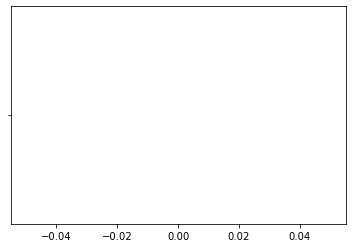

In [263]:
import matplotlib.pyplot as plt
plt.plot("")

## Results

In [264]:
# import matplotlib.pyplot as plt
# plt.plot(train_losses, label="train")
# plt.plot(valid_losses, label="validation")
# plt.title("Losses")
# plt.legend()
# plt.show()

In [265]:
# plt.plot(train_accs, label="train")
# plt.plot(valid_accs, label="validation")
# plt.title("Accuracy")
# plt.legend()
# plt.show()